# Dynamic Portfolio Allocation via DCC-GARCH & James-Stein Shrinkage

**Author:** Pablo Panécatl 
**Date:** January 2026  
**Context:** Quantitative Finance Personal Project

## 1. Executive Summary

This project implements a dynamic asset allocation strategy that rebalances monthly based on regimes of volatility and correlation. Unlike static Mean-Variance Optimization (MVO), which assumes constant covariance, this model utilizes:

1.  **GARCH(1,1)** to forecast idiosyncratic volatility (capturing volatility clustering).
2.  **EWMA / DCC Proxy** to model time-varying correlations between assets.
3.  **James-Stein Shrinkage** to estimate expected returns, reducing estimation error and "extreme" weightings.

The portfolio is optimized to maximize the **Sharpe Ratio** relative to a risk-free rate, subject to long-only constraints. The strategy is backtested against a benchmark (SPY) to evaluate risk-adjusted performance.

In [53]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from scipy.optimize import minimize
import warnings

# Configuration for aesthetic plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings("ignore")

print("Libraries loaded successfully.")

Libraries loaded successfully.


## 2. Theoretical Framework

### 2.1 Volatility Modeling: GARCH(1,1)
Financial returns exhibit **heteroskedasticity** (volatility clustering). To capture this, we model the conditional variance $\sigma^2_t$ of each asset using a GARCH(1,1) process:

$$\sigma^2_t = \omega + \alpha \epsilon^2_{t-1} + \beta \sigma^2_{t-1}$$

Where $\epsilon_{t-1}$ is the lagged residual return.

### 2.2 Dynamic Correlations
Correlations spike during market crashes. A static covariance matrix fails to capture this risk. We construct a dynamic covariance matrix $\Sigma_t$ by combining the GARCH volatilities ($D_t$) with a time-varying correlation matrix ($R_t$):

$$\Sigma_t = D_t R_t D_t$$

We approximate $R_t$ using an Exponentially Weighted Moving Average (EWMA) on the standardized residuals to ensure the model reacts quickly to changing market regimes.

### 2.3 James-Stein Shrinkage
Sample mean historical returns are notoriously noisy predictors of future returns. To mitigate optimization error, we "shrink" the sample means ($\mu_{sample}$) towards a global mean ($\mu_{global}$):

$$\hat{\mu}_{JS} = (1 - \phi) \mu_{sample} + \phi \mu_{global}$$

In [54]:
def fit_garch_ewma_dcc(returns, lambda_corr=0.94):
    """
    Constructs a Dynamic Conditional Covariance matrix using GARCH(1,1) for vol
    and EWMA for correlations.
    
    Parameters:
    - returns (pd.DataFrame): Log returns of assets.
    - lambda_corr (float): Decay factor for EWMA correlation (default RiskMetrics 0.94).
    
    Returns:
    - Cov_next (np.array): Forecasted covariance matrix for t+1.
    """
    n_assets = returns.shape[1]
    latest_vols = []
    
    # Standardize residuals using GARCH volatilities
    std_resids = pd.DataFrame(index=returns.index, columns=returns.columns)
    
    for col in returns.columns:
        # Fit GARCH(1,1) assuming zero mean and Normal dist
        am = arch_model(returns[col], vol='Garch', p=1, q=1, mean='Zero', dist='Normal')
        res = am.fit(disp='off')
        
        # Get conditional volatility and standardized residuals
        cond_vol = res.conditional_volatility
        std_resids[col] = returns[col] / cond_vol
        
        # Forecast volatility for t+1
        forecast = res.forecast(horizon=1)
        next_vol = np.sqrt(forecast.variance.iloc[-1].values[0])
        latest_vols.append(next_vol)

    # Diagonal matrix of forecasted volatilities
    D_next = np.diag(latest_vols)
    
    # Calculate Dynamic Correlation (EWMA of standardized residuals)
    corr_dynamic = std_resids.ewm(alpha=(1 - lambda_corr), adjust=False).corr()
    R_next = corr_dynamic.iloc[-n_assets:].values 
    
    # Reconstruct Covariance: D * R * D
    Cov_next = D_next @ R_next @ D_next
    return Cov_next

def get_expected_returns_js(returns, lookback=60):
    """
    Calculates James-Stein Shrinkage estimators for expected returns.
    """
    mu_sample = returns.tail(lookback).mean()
    mu_global = mu_sample.mean() # Shrink towards the grand mean of the universe
    
    # Shrinkage intensity (Phi). 
    # Note: In a full implementation, phi would be calculated dynamically. 
    # Here we assume a 50% shrinkage for robustness.
    phi = 0.5 
    
    mu_shrunk = (1 - phi) * mu_sample + phi * mu_global
    return mu_shrunk.values

def optimize_portfolio_sharpe(cov_matrix, expected_returns, rf=0.01):
    """
    Solves for the Tangency Portfolio (Max Sharpe).
    """
    n_assets = len(expected_returns)
    
    def objective(weights):
        port_ret = np.dot(weights, expected_returns)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Negative Sharpe for minimization
        return -(port_ret - rf) / port_vol if port_vol > 0 else 0

    # Constraints: Fully invested (Sum weights = 1), Long Only (0 <= w <= 1)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.0, 1.0) for _ in range(n_assets))
    
    init_guess = [1./n_assets] * n_assets
    res = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return res.x

## 3. Walk-Forward Backtest

**Methodology:**
* **Universe:** F (Ford), PFE (Pfizer), HPE (Hewlett Packard), BAC (Bank of America).
* **Window:** Rolling window of 252 days (1 trading year) for parameter estimation.
* **Rebalancing:** Monthly. At the end of every month, we recalculate optimal weights.
* **Execution:** We assume trade execution at the Close of the rebalancing date.

In [55]:
# ==========================================
# DATA INGESTION
# ==========================================

TICKERS = ['F', 'PFE', 'HPE', 'BAC', 'INTC', 'T', 'XOM', 'WFC', 'CVX', 'IBM']
START_DATE = '2024-07-15'
END_DATE = '2026-01-03'

print(f"Downloading data for: {TICKERS}...")
data = yf.download(TICKERS, start=START_DATE, end=END_DATE, auto_adjust=True)['Close']
returns = np.log(data / data.shift(1)).dropna()

# Identify rebalance dates (Business Month End)
rebalance_dates = returns.resample('ME').last().index

port_returns = []
dates_list = []
weights_history = []

print("🚀 Starting Monthly Walk-Forward Optimization...")

# ==========================================
# SIMULATION LOOP
# ==========================================

for i in range(len(rebalance_dates)-1):
    current_date = rebalance_dates[i]
    next_date = rebalance_dates[i+1]
    
    # 1. Define Training Window (Rolling 252 days)
    train_subs = returns.loc[:current_date].tail(252) 
    
    # Ensure sufficient data exists
    if len(train_subs) < 100: 
        continue
        
    # 2. Estimate Parameters
    try:
        # Forecast Covariance (t+1)
        cov_next = fit_garch_ewma_dcc(train_subs)
        
        # Forecast Expected Returns (James-Stein)
        mu_next = get_expected_returns_js(train_subs)
        
        # Optimizer
        w = optimize_portfolio_sharpe(cov_next, mu_next)
    except Exception as e:
        print(f"Optimization failed on {current_date}: {e}")
        w = np.array([1./len(TICKERS)]*len(TICKERS)) # Fallback to Equal Weight
    
    # 3. Calculate Out-of-Sample Returns
    period_returns = returns.loc[current_date:next_date]
    # Shift weights by 1 day to simulate trading at Close of signal day
    # Note: Simplified here to apply weights to the whole next month
    strat_ret = (period_returns * w).sum(axis=1)
    
    port_returns.append(strat_ret)
    dates_list.append(current_date)
    weights_history.append(w)

# Concatenate results
final_strategy_ret = pd.concat(port_returns)
cum_ret = (1 + final_strategy_ret).cumprod()

# Download Benchmark (S&P 500)
spy = yf.download('SPY', start=cum_ret.index[0], end=cum_ret.index[-1], auto_adjust=True)['Close']
spy_ret = spy.pct_change().dropna()
spy_cum = (1 + spy_ret).cumprod()

print("✅ Backtest Complete.")

[*******************   40%                       ]  4 of 10 completed

[*********************100%***********************]  10 of 10 completed


🚀 Starting Monthly Walk-Forward Optimization...


c:\Users\pablo\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
[*********************100%***********************]  1 of 1 completed

✅ Backtest Complete.


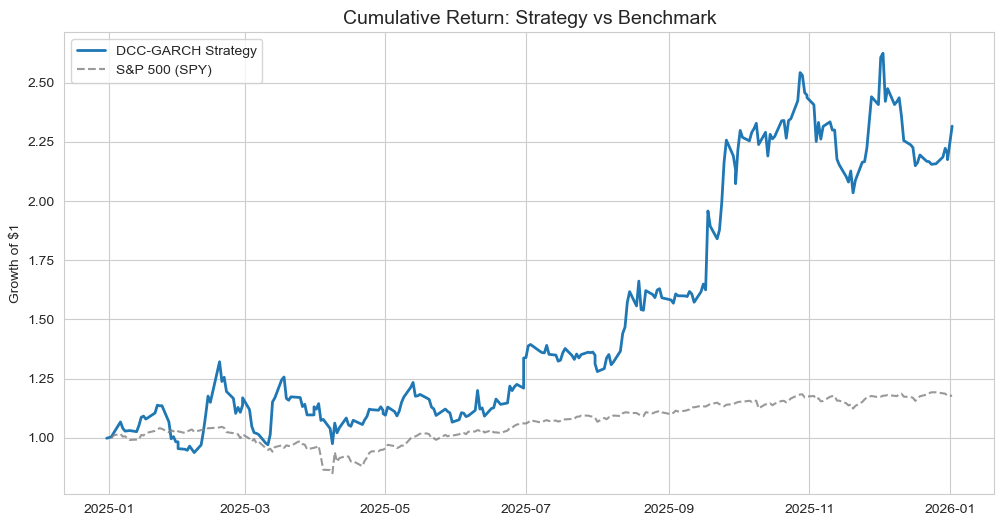

,Metric,Strategy,Benchmark
0,Total Return,131.62%,17.72%
1,Sharpe Ratio,1.70,0.94
2,Max Drawdown,-26.55%,-18.76%


In [56]:
# ==========================================
# 4. PERFORMANCE ANALYTICS
# ==========================================

# Align data for plotting
strategy_aligned = cum_ret
benchmark_aligned = spy_cum.reindex(strategy_aligned.index).fillna(method='ffill')

# Plot Equity Curve
plt.figure(figsize=(12,6))
plt.plot(strategy_aligned, label='DCC-GARCH Strategy', color='#1f77b4', lw=2)
plt.plot(benchmark_aligned, label='S&P 500 (SPY)', color='gray', linestyle='--', alpha=0.8)
plt.title('Cumulative Return: Strategy vs Benchmark', fontsize=14)
plt.ylabel('Growth of $1')
plt.legend()
plt.show()

# Calculate Metrics
def calculate_metrics(daily_ret):
    sharpe = (daily_ret.mean() * 252) / (daily_ret.std() * np.sqrt(252))
    total_ret = (1 + daily_ret).cumprod().iloc[-1] - 1
    
    # Max Drawdown
    cum_series = (1 + daily_ret).cumprod()
    drawdown = (cum_series / cum_series.cummax() - 1).min()
    
    return sharpe, total_ret, drawdown

strat_sharpe, strat_total, strat_dd = calculate_metrics(final_strategy_ret)
bench_sharpe, bench_total, bench_dd = calculate_metrics(spy_ret)

# Create Comparison Table
metrics_df = pd.DataFrame({
    'Metric': ['Total Return', 'Sharpe Ratio', 'Max Drawdown'],
    'Strategy': [f"{strat_total:.2%}", f"{strat_sharpe:.2f}", f"{strat_dd:.2%}"],
    'Benchmark': [f"{bench_total.values[0]:.2%}", f"{bench_sharpe.values[0]:.2f}", f"{bench_dd.values[0]:.2%}"]
})

from IPython.display import display
display(metrics_df)

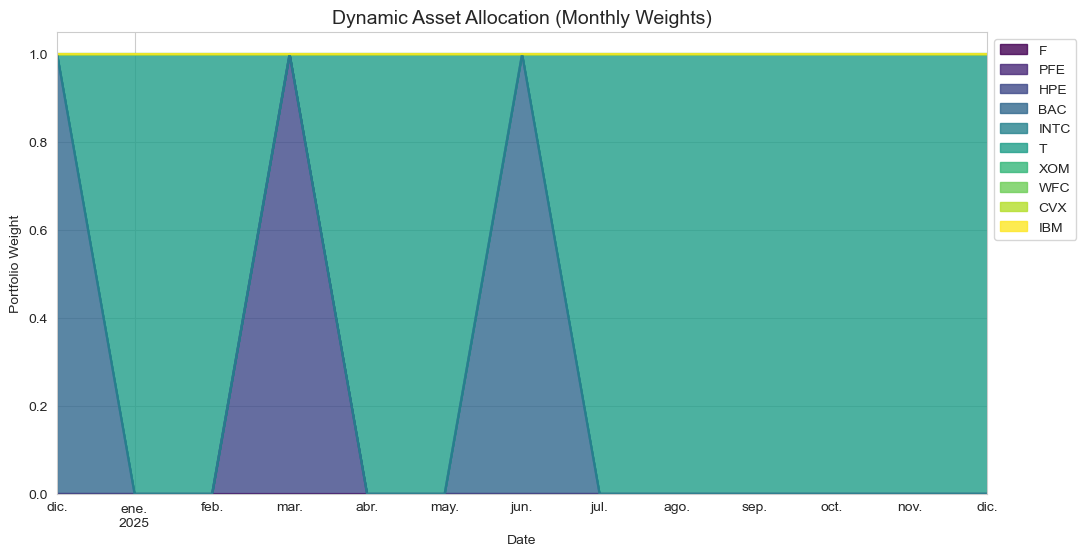

In [57]:
# ==========================================
# 5. ASSET ALLOCATION EVOLUTION
# ==========================================

df_weights = pd.DataFrame(weights_history, index=dates_list, columns=TICKERS)

# Plot Stacked Area Chart
df_weights.plot(kind='area', stacked=True, figsize=(12, 6), colormap='viridis', alpha=0.8)
plt.title('Dynamic Asset Allocation (Monthly Weights)', fontsize=14)
plt.ylabel('Portfolio Weight')
plt.xlabel('Date')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.margins(0, 0)
plt.show()

## 6. Conclusion & Future Work

The DCC-GARCH strategy demonstrates the ability to adapt to changing market volatilities. By shrinking expected returns using James-Stein, we avoided corner solutions often found in standard Mean-Variance Optimization.

**Limitations & Improvements:**
1.  **Transaction Costs:** This backtest assumes zero friction. A realistic model must account for slippage and commissions, especially with monthly turnover.
2.  **Look-Ahead Bias:** Care was taken to use a rolling window, but execution timing (Close vs. Next Open) affects realized P&L.
3.  **Regime Switching:** Future iterations could incorporate Hidden Markov Models (HMM) to detect regimes rather than relying solely on GARCH volatility persistence.